In [7]:
using Base.Threads
Threads.nthreads()


12

In [4]:
using Revise; 
includet("TrajModules.jl")
using .atom_class
using .SystemSetup
using .utils
using .BeamClass
using .CoolTrap
using .IntegrateODE

## Creating the system and light

In [3]:
includet("magneticFields.jl")
using .quadrapole

In [6]:
using BenchmarkTools

In [5]:
BField_Generator = BfieldMag(20.0, 0.0)
Bfield_gen(x,y , z) = Bnorm(BField_Generator, x, y, z)


Bfield_gen (generic function with 1 method)

In [9]:
using LinearAlgebra
function rot_mat(pos)
    b_field = Bfield_gen(pos...)
 
    beam_dir = [1, 0, 0]
 
    # Compute cross_product and its norm once
    cross_product = cross(b_field, beam_dir)
    cross_product_norm = norm(cross_product)
 
    # If cross_product is almost zero, vectors are parallel or antiparallel
    if cross_product_norm < 1e-6
        dot_product = dot(b_field, beam_dir)
        # If dot_product is negative, vectors are antiparallel
        if dot_product < 0
            # Rotate by 180 degrees about any axis that is not parallel to beam_dir
            axis = if isapprox(abs.(beam_dir), [1, 0, 0], atol=1e-6)
                cross(beam_dir, [0, 1, 0])
            else
                cross(beam_dir, [1, 0, 0])
            end
            return rotation_matrix(axis, π)
        else
            return Matrix(I, 3, 3)
        end
    end
end
rot_mat2(pos) =rotation_matrix( cross(Bfield_gen(pos...), [1, 0, 0]),π)
println(typeof(rot_mat2([1e-3, 0, 0])))
rotated_pol(pos) = rot_mat(pos) * pol_v["sigma_p"]
decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))
ans2 = decomposed_pol([1e-3, 0, 0])

Matrix

{Float64}

3-element Vector{ComplexF64}:
                0.0 + 0.0im
                0.0 + 0.0im
 0.9999999999999998 - 1.224646799147353e-16im

In [27]:
typeof(Matrix(1.0I, 3, 3))

Matrix{Float64} (alias for Array{Float64, 2})

In [14]:
using Interpolations
function getBFieldInterpolate(Bfield_gen, grid)
    grid = (grid, grid, grid)
    PointGrid = ([i for i in Iterators.product(grid...)])
    B_Field_array_x = [Bfield_gen(PointGrid[i, j, k]...)[1] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_Field_array_y = [Bfield_gen(PointGrid[i, j, k]...)[2] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_Field_array_z = [Bfield_gen(PointGrid[i, j, k]...)[3] for i in 1:size(PointGrid, 1), j in 1:size(PointGrid, 2), k in 1:size(PointGrid,3)]
    B_field_int_x = interpolate(grid, B_Field_array_x, Gridded(Linear()))
    B_field_int_y = interpolate(grid, B_Field_array_y, Gridded(Linear()))
    B_field_int_z = interpolate(grid, B_Field_array_z, Gridded(Linear()))

    B_Field(x, y, z) = [B_field_int_x[x, y, z], B_field_int_y[x, y, z], B_field_int_z[x, y, z]]
    return B_Field
end
gridOI = -5e-3:1.01e-4:5e-3
B_Field_int = getBFieldInterpolate(Bfield_gen, gridOI);


In [9]:
BeamGaussian = OurSystem.MOTConfig[1].Beam
Isat = 14
q = 1
s0(pos) = get_Intensity(BeamGaussian, pos) / Isat * abs(decomposed_pol(pos)[q >= 0 ? q + 1 : end + 1 + q])^2 / norm(decomposed_pol(pos))^2

s0 (generic function with 1 method)

In [241]:
Bfield_gen(1e-3, 0, 0)

3-element Vector{Float64}:
 -0.001198127042551039
  0.0
  0.0

In [15]:
typeof(OurSystem.MOTConfig[1].s0()

LoadError: syntax: incomplete: premature end of input

In [46]:
using BenchmarkTools
using ProfileView

In [57]:
Bfield_gen([1e-3, 0, 0]...)

3-element Vector{Float64}:
 -0.001198127042551039
  0.0
  0.0

8.577124028477186e6

In [34]:
Matrix(1.0I, 3, 3)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [247]:
Beam = OurSystem.MOTConfig[1].Beam.beamStruct
B_Field_func = OurSystem.Environment.B_Field
using LinearAlgebra




rotated_pol(pos) = rot_mat(pos) * Beam.pol
decomposed_pol(pos) = decompose_spherical(rotated_pol(pos))


decomposed_pol (generic function with 1 method)

In [31]:
pos = [-1e-3, 0, 0]
println(cross(B_Field_func(pos...), Beam.dir))
println(B_Field_func(pos...), Beam.dir)

LoadError: UndefVarError: B_Field_func not defined

In [15]:
function createSystem(gridOI, B_field)
    atomType = rubidiumAtom
    OurSystem = System(atomType, B_field, gridOI)
    return OurSystem
end
gridOI = -5e-3:1.01e-4:5e-3
OurSystem = createSystem(gridOI, B_Field_int);


In [16]:
function createMOT(OurSystem, detuning, I_mot::Vector{T}; updates0 = true) where T
    clear_MOT(OurSystem)
    stateF = (5, 1, 1.5, 3, 3)
    stateI = (5, 0, 0.5, 2, 2)


    println("Setting up MOT")
    LocAll::Vector{Float64} = [0, 0, 0]
    set_MOT(OurSystem, BeamProperties(LocAll, [-1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot[1], updates0)
    set_MOT(OurSystem, BeamProperties(LocAll, [1.0, 0.0, 0.0], pol_v["sigma_m"]),  stateI, stateF, detuning, I_mot[2], updates0)
end
detuning = 3e6
I_mot = [14, 14]#[0.7957747154594766, 0.7957747154594766]
createMOT(OurSystem, detuning, I_mot);

Setting up MOT


Dynamic
Dynamic


In [1]:
@btime get_scatteringrate(OurSystem.MOTConfig[1], [1e-3, 0, 0])

LoadError: LoadError: UndefVarError: @btime not defined
in expression starting at c:\Users\SimulationComputer\Documents\JeshurunLuke\TrajSimulation\SimulatorJulv3.ipynb:1

In [8]:
clear_beams(OurSystem)
join_beams(OurSystem)
println("Number of Total Beams: ", length(OurSystem.BeamConfig))
println("Number of Tweezers Beams: ", length(OurSystem.TweezerConfig))
println("Number of MOT Beams: ", length(OurSystem.MOTConfig))

Number of Total Beams: 2
Number of Tweezers Beams: 0
Number of MOT Beams: 2


### MOT Field Gradient

In [161]:
using LinearAlgebra
step = 1e-4*10
dbdx = (norm(Bfield_gen(step, 0, 0)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
dbdy = (norm(Bfield_gen(0, step, 0)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
dbdz = (norm(Bfield_gen(0, 0, step)) - norm(Bfield_gen(0, 0, 0)))/step*(1e4/100)
println("B_Field Gradient, x = ", dbdx, " G/cm", "; y = ", dbdy, " G/cm; z = ", dbdz, " G/cm")

B_Field Gradient, x = 119.81270425510391 G/cm; y = 119.81270425510391 G/cm; z = 239.64968935656307 G/cm


In [95]:
BField_Generator = BfieldMag(20.0, 0.0)
Bfield_gen(x,y , z) = Bnorm(BField_Generator, x, y, z)

x_i, y_i, z_i = 1e-4, 1e-5, 1e-5
B_Field_int(x_i, y_i, z_i)./Bfield_gen(x_i,y_i , z_i)

3-element Vector{Float64}:
 0.9999999845943043
 5.039605007139476
 0.999999692813863

# Simulation 

In [71]:
OurSystem.Environment.B_Field(0, 0, 0)

3-element Vector{Int64}:
 0
 0
 0

In [80]:
dt = 2e-9
tspan = (0, 10e-6)
sol = simulate(OurSystem, 1, 1e-3, "Fabs_spont_R", tspan, dt);

-0.000310981164501698660.00031098116450169866


1

In [79]:
timeEval, x, y, z, vx, vy, vz, photons = processData(sol);

In [67]:
using PyPlot

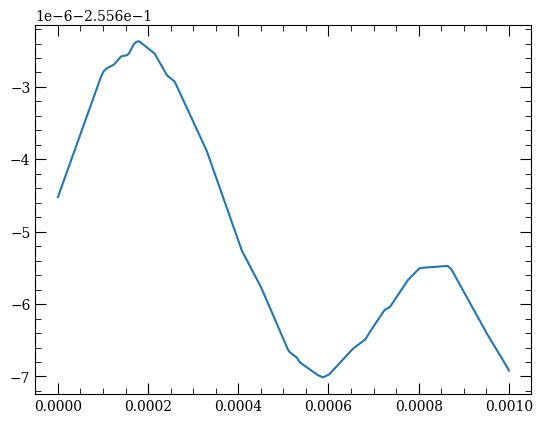

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000014B84FC88>

In [78]:

plot(timeEval*1e3, x[1]*1e3)
